[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# Multiple Schemas

## Review

We just covered state schema and reducers.

Typically, all graph nodes communicate with a single schema.

Also, this single schema contains the graph's input and output keys / channels.

## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

In [12]:
%%capture --no-stderr
%pip install --quiet -U langgraph pydantic

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

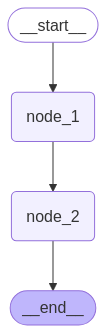

In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema.

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

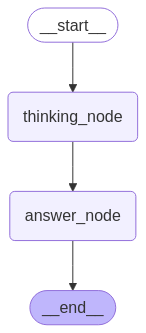

In [4]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Notice that the output of invoke contains all keys in `OverallState`.

In [ ]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph.

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`.

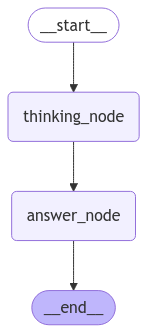

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}

In [ ]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the `output` schema constrains the output to only the `answer` key.

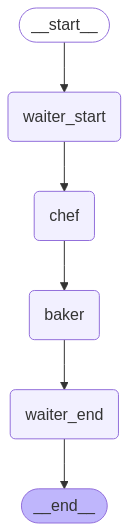

state for waiter start: {'dish': 'pizza'}
state for chef: {'dish': 'pizza', 'time_taken': 2}
state for baker: {'dish': 'pizza', 'ingredients': ['flour', 'tomato', 'cheese', 'basil'], 'time_taken': 12}
state for waiter end: {'dish': 'pizza', 'ingredients': ['flour', 'tomato', 'cheese', 'basil'], 'time_taken': 17}


{'served_dish': 'pizza', 'time_taken': 17}

In [20]:
from typing import Literal
class InputState(TypedDict):
	dish: str

class OutputState(TypedDict):
	served_dish: str
	time_taken: float

class InternalState(TypedDict):
	dish: str
	ingredients: list[str]
	cook_type: Literal["baked", "steamed", "fried"]
	time_taken: float
	served_dish: str


# now we can have nodes like

def waiterStart(state: InputState) -> InternalState:
  print(f"state for waiter start: {state}")
  return {"time_taken": 2} # the good part is that we do not even need to add the dish explicitly, it is there?

def chef(state: InternalState) ->InternalState:
  print(f"state for chef: {state}")
  return {"ingredients": ["flour", "tomato", "cheese", "basil"], "time_taken":state["time_taken"]+10}

def baker (state: InternalState) ->InternalState:
  print(f"state for baker: {state}")
  return {"time_taken": state["time_taken"]+5}

def waiterEnd(state: InternalState) -> OutputState:
  print(f"state for waiter end: {state}")
  return {"served_dish": "pizza"}


graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("waiter_start", waiterStart)
graph.add_node("chef", chef)
graph.add_node("baker", baker)
graph.add_node("waiter_end", waiterEnd)
graph.add_edge(START, "waiter_start")
graph.add_edge("waiter_start", "chef")
graph.add_edge("chef", "baker")
graph.add_edge("baker", "waiter_end")
graph.add_edge("waiter_end", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"dish":"pizza"})


In [19]:
!python --version

Python 3.11.12


## WITH PYDANTIC?
with pydantic do I still need not define `dish` to the waiter start?

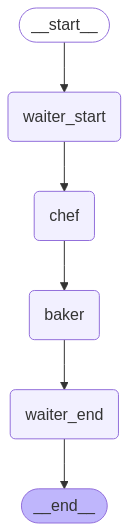

state for waiter start: dish='pizza'
state for chef: dish='pizza' ingredients=[] cook_type='baked' time_taken=2.0 served_dish=''
state for baker: dish='pizza' ingredients=['flour', 'tomato', 'cheese', 'basil'] cook_type='baked' time_taken=12.0 served_dish=''
state for waiter end: dish='pizza' ingredients=['flour', 'tomato', 'cheese', 'basil'] cook_type='baked' time_taken=17.0 served_dish=''
{'served_dish': 'pizza', 'time_taken': 17.0}


In [13]:
from typing import Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define Pydantic models
class InputState(BaseModel):
    dish: str

class OutputState(BaseModel):
    served_dish: str
    time_taken: float

class InternalState(BaseModel):
    dish: str = ""
    ingredients: list[str] = Field(default_factory=list)
    cook_type: Literal["baked", "steamed", "fried"] = "baked"
    time_taken: float = 0.0
    served_dish: str = ""

# Now we can have nodes like

def waiter_start(state: InputState) -> InternalState:
    print(f"state for waiter start: {state}")
    return InternalState(dish=state.dish, time_taken=2)

def chef(state: InternalState) -> InternalState:
    print(f"state for chef: {state}")
    state.ingredients = ["flour", "tomato", "cheese", "basil"]
    state.time_taken += 10
    return state

def baker(state: InternalState) -> InternalState:
    print(f"state for baker: {state}")
    state.time_taken += 5
    return state

def waiter_end(state: InternalState) -> OutputState:
    print(f"state for waiter end: {state}")
    return OutputState(served_dish="pizza", time_taken=state.time_taken)

# Set up the graph
OverallState = InternalState  # Define OverallState properly

graph = StateGraph(OverallState, input=InputState, output=OutputState)

graph.add_node("waiter_start", waiter_start)
graph.add_node("chef", chef)
graph.add_node("baker", baker)
graph.add_node("waiter_end", waiter_end)

graph.add_edge(START, "waiter_start")
graph.add_edge("waiter_start", "chef")
graph.add_edge("chef", "baker")
graph.add_edge("baker", "waiter_end")
graph.add_edge("waiter_end", END)

compiled_graph = graph.compile()

# View
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

# Invoke
test_output = compiled_graph.invoke({"dish": "pizza"})
print(test_output)
